In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import pyforfluids as pff
import matplotlib.pyplot as plt
float64 = "float64"

In [2]:

kij = np.array([
    [0, 0],
    [0, 0],
], dtype=float64)

lij = 0 * 1.5*kij

z = np.array([0.3, 0.7], dtype=float64)
p = 2.0
v = 100.0
t = 150.0

tc = np.array([190, 304], dtype=float64)
pc = np.array([45, 74], dtype=float64)
w = np.array([0.19, 0.1], dtype=float64)

penerob = pff.models.cubic.PR76(tc, pc, w)
mixrule = pff.models.mixingrules.ClassicVdW(kij, lij)
armodel = pff.models.cubic.CubicEoS(penerob, mixrule)

system = pff.models.system.System(armodel, None, None)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


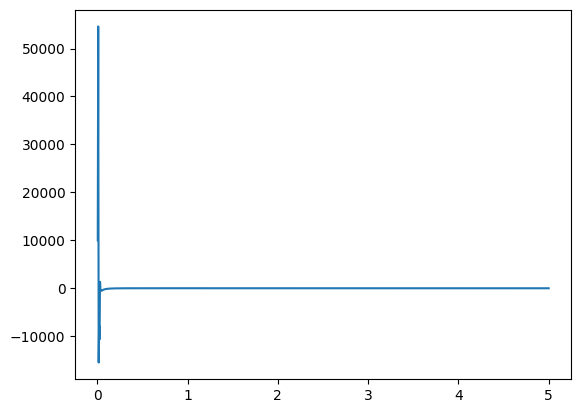

In [3]:

vs = np.linspace(0, 5, 1000)

ps = [system.pressure(z, v, t) for v in vs]

plt.plot(vs, ps)
plt.show()

In [4]:
a = penerob.attractive_parameter(z, v, t)
b = penerob.repulsive_parameter(z, v, t)
c = penerob.volume_shift(z, v, t)

In [14]:
times = []

f = lambda x: (mixrule.mix_a(z, v, t, a), mixrule.mix_a(z, v, t, b), mixrule.mix_c(z, v, t, c))
for n in range(0, 100000, 1000):
    for i in range(n):
        time = %timeit -o f(0)

23.3 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
21.1 µs ± 928 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
20.7 µs ± 455 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
20.7 µs ± 813 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
21.6 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
20.2 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
21.8 µs ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
21.3 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
20.8 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
20.6 µs ± 719 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
17.5 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
16.8 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
25.5 µs ± 3.57 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
26.4 µs ± 1.46 µs per loop (

KeyboardInterrupt: 

In [15]:
amix, bmix, cmix = f(0)

In [17]:
amix, bmix, cmix

(Array(4.49988942, dtype=float64),
 Array(0.02679299, dtype=float64),
 Array(0., dtype=float64))

In [20]:
amix, bmix, cmix, _, _ = mixrule.mix(z, v, t, a, b, c, [0], [0])
amix, bmix, cmix

(Array(7.35020055, dtype=float64),
 Array(0.04227259, dtype=float64),
 Array(0., dtype=float64))

In [9]:
%%timeit
for i in range(1000):
    amix, bmix, cmix, _, _ = mixrule.mix(z, v, t, a, b, c, [0], [0])

16.1 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
mixrule.mix_a

Array(0, dtype=int64, weak_type=True)